In [ ]:
#Summary


# Inputs: Storage, Inflow, Outflow, Precipitation. (last 60 days). Not using level because maybe the network learns too much based on it.
# Outputs: Storage 30 days, 60 days, 90 days ahead
# Daily data 10 years.

Pipeline
- Data Exploration
    - Plot each variable vs time
    - Plot auto correlation
    - Plot trend, seasonanility of storage (ETS Decomposition)

- Feature Engineering
    - Remove low correlating features, level
    - Add day, month, year (better as sinusoids)
    - Remove missing data chunks (or impute using RNN)
    - normalize
    - cross-validate (methods for time-series only)
    - build batches for model(windowing function)

- Model Experimentation
    - Build general function for all models
    - build baseline (ARIMA)
    - Experiment with
        - learning rate (cyclic lr, reducing_on_plateau)
        - early stopping (switch off during other exps)
        - dropout, layernorm, depth, convolution
        - LSTM vs wavenet vs dense vs attention mechanisms
    - plot loss curves, performance. then repeat exps
    - save best models

- Predictions
    - load models
    - build predictions (for 30, 60, 90 days X dam)
    - performance. choose best model.
    - table and visualization

- Explainability
    - SHAP (Feature Importance)
      


In [ ]:
#@title #####Mount Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_path = '/content/gdrive/My Drive/Colab Notebooks/wave2web/'
%cd '/content/gdrive/My Drive/Colab Notebooks/wave2web/'

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/wave2web


In [ ]:
# @title ####imports
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Configuration

In [ ]:
#Parameters
DAM='krs'
START_DATE='2013-06-11'
END_DATE='2020-12-16'

LABEL_WIDTH = 1 #for multiple predictions
INPUT_WIDTH = 90 # previous timesteps
SHIFT = 90 # predict timesteps ahead
LABEL_WIDTH_DISPLAY = 20 #how many predictions to plot at once. The model still trains only on LABEL_WIDTH, this is for plotting
#for instance: train a model on 60 days data, predict Single output 30 days ahead, show 40 such outputs at once in plot.

# Data Cleaning and Transformation

In [ ]:
inputs=pd.read_csv(f'{DAM}_db.csv')
inputs=inputs.drop(['inflow_simulated'], axis=1)
inputs=inputs.drop(['level'], axis=1)
inputs

,date,storage,inflow,outflow,rain
0,1/1/2011,46.42,2029,2000.0,0.103059
1,1/2/2011,46.54,3084,1490.0,0.000000
2,1/3/2011,46.64,2776,1491.0,0.000000
3,1/4/2011,46.69,2311,1491.0,0.000000
4,1/5/2011,46.70,1847,1491.0,0.000000
...,...,...,...,...,...
3648,12/27/2020,NaN,NaN,NaN,0.000000
3649,12/28/2020,NaN,NaN,NaN,0.000000
3650,12/29/2020,NaN,NaN,NaN,0.000000
3651,12/30/2020,NaN,NaN,NaN,0.000000


In [1]:
inputs.info(), inputs.describe()

NameError: ignored

In [ ]:
#about 10% data missing
#level, inflow has non-numeric values, hence not showing in describe()
# there seem to be not any outliers or fill values such as '-999' etc.

In [ ]:
#inputs['level']=pd.to_numeric(inputs['level'], errors='coerce')
inputs['inflow']=pd.to_numeric(inputs['inflow'], errors='coerce')
inputs['date']=pd.to_datetime(inputs['date'])
inputs.describe()

,storage,inflow,outflow,rain
count,3307.000000,3306.000000,3307.000000,3653.000000
mean,28.048990,4916.569268,4844.267312,3.804885
std,14.356327,10698.975857,9507.320922,7.577868
min,0.000000,0.000000,0.000000,0.000000
25%,14.295000,319.000000,715.500000,0.000000
50%,27.380000,1717.000000,3703.000000,0.425903
75%,42.090000,5436.500000,5160.000000,4.375793
max,49.450000,204200.000000,151365.000000,97.609635


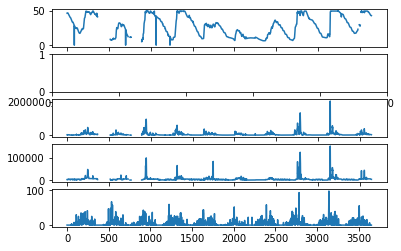

In [ ]:
#all seems ok. still plotting to see
fig,axs=plt.subplots(5)
axs[0].plot(inputs['storage'])
#axs[1].plot(inputs['level'])
axs[2].plot(inputs['inflow'])
axs[3].plot(inputs['outflow'])
axs[4].plot(inputs['rain'])

# most missing values are in a continuous range. So simply omitting for now
# is storage and level almost the same?

In [ ]:
#How to handle missing values in time-series data with strong seasonality?
# 1. simply remove the data
# 2. data imputation (method depends on keeping in mind the seasonality)

# For quick testing: https://www.kaggle.com/juejuewang/handle-missing-values-in-time-series-for-beginners
# for understanding: https://www.nature.com/articles/s41598-018-24271-9

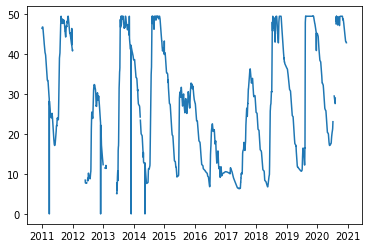

In [ ]:
plt.plot(inputs['date'], inputs['storage'])
# most missing values are in a continuous range. So simply omitting for now
#my (untested) assumption is that if we simply omit these values, there are only 2-3 places where our network will perform bad. These will be ignored in a model that does not overfit

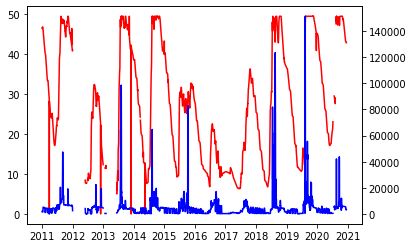

In [ ]:
fig, axs=plt.subplots()
axs.plot(inputs['date'], inputs['storage'], color='red')
axs2=axs.twinx() #data had different range. so plotted on separate y-axes
axs2.plot(inputs['date'], inputs['outflow'], color='blue')
plt.show()

In [ ]:
#Method 1: removing missing values
inputs=inputs.dropna()
inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3306 entries, 0 to 3637
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     3306 non-null   datetime64[ns]
 1   storage  3306 non-null   float64       
 2   inflow   3306 non-null   float64       
 3   outflow  3306 non-null   float64       
 4   rain     3306 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 155.0 KB


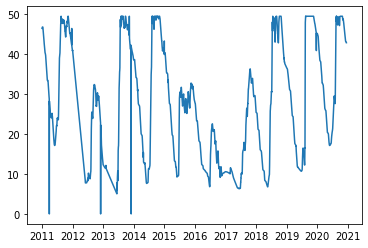

In [ ]:
plt.plot(inputs['date'], inputs['storage'])

In [ ]:
# #ETS (Error- Trend - Seasonality)
# from statsmodels.tsa.seasonal import seasonal_decompose
# # ETS Decomposition of storage and date 
# subset=inputs[['storage', 'date']]
# subset=subset.set_index('date')
# subset=subset.asfreq('D')

# result = seasonal_decompose(subset['storage'], 
#                             model ='additive')
  
# # ETS plot 
# result.plot()

In [ ]:
#converting date to a better, smoother feature (since data has cyclic tendencies yearly, it is better to show that Dec-2015 is as similar to Jan-2016  as  March is to april)
#To-do: Fast Fourier Transform to find correct frequencies
#https://stats.stackexchange.com/questions/311494/best-practice-for-encoding-datetime-in-machine-learning

#For now, not doing anything, just finding numeric values of date, month, year

In [ ]:
# day=30.0
# month=12.0
# year=365
# inputs['Day sin'] = np.sin(inputs['day'] * (2 * np.pi / day))
# inputs['Day cos'] = np.cos(inputs['day'] * (2 * np.pi / day))
# inputs['Month sin'] = np.sin(inputs['month'] * (2 * np.pi / month))
# inputs['Month cos'] = np.cos(inputs['month'] * (2 * np.pi / month))
# inputs['Year sin'] = np.sin(inputs['year'] * (2 * np.pi / year))
# inputs['Year cos'] = np.cos(inputs['year'] * (2 * np.pi / year))
# inputs
# plt.plot(np.array(inputs['Month sin'])[:100])
inputs['day']=pd.DatetimeIndex(inputs['date']).day
inputs['month']=pd.DatetimeIndex(inputs['date']).month
inputs['year']=pd.DatetimeIndex(inputs['date']).year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [ ]:
# using only data from 2013-06-11 to 2020-12-16' which is mostly continous
inputs=inputs[(inputs.date>=START_DATE) & (inputs.date<=END_DATE)]
#inputs

In [ ]:
inputs=inputs.drop(['date'],axis=1)
inputs

,storage,inflow,outflow,rain,day,month,year
892,5.11,198.0,775.0,7.671828,11,6,2013
893,5.06,227.0,768.0,12.384824,12,6,2013
894,5.03,481.0,762.0,3.078275,13,6,2013
895,5.12,1782.0,763.0,6.922709,14,6,2013
896,7.79,6231.0,798.0,8.437897,15,6,2013
...,...,...,...,...,...,...,...
3633,43.04,3496.0,3308.0,0.000000,12,12,2020
3634,43.02,3197.0,3300.0,0.000000,13,12,2020
3635,42.98,3026.0,3273.0,0.000000,14,12,2020
3636,42.92,2530.0,3068.0,0.000000,15,12,2020


In [ ]:
inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2720 entries, 892 to 3637
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   storage  2720 non-null   float64
 1   inflow   2720 non-null   float64
 2   outflow  2720 non-null   float64
 3   rain     2720 non-null   float64
 4   day      2720 non-null   int64  
 5   month    2720 non-null   int64  
 6   year     2720 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 170.0 KB


In [ ]:
# # Importing required libraries
# from statsmodels.tsa.seasonal import seasonal_decompose
# # ETS Decomposition
# result = seasonal_decompose(db_1['storage'], model ='multiplicative')
  
# # ETS plot 
# result.plot()

# Setting up for models

In [ ]:
#setup based on https://www.tensorflow.org/tutorials/structured_data/time_series
df=inputs

#split data 70%-20%-10% (train-validation-test)
#To-do: Cross-validation
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
test_df

,storage,inflow,outflow,rain,day,month,year
3345,33.38,166.0,5838.0,0.000000,28,2,2020
3346,33.07,248.0,3721.0,0.742066,29,2,2020
3347,32.79,172.0,3283.0,0.896882,1,3,2020
3348,32.72,631.0,1326.0,4.008976,2,3,2020
3349,32.74,912.0,524.0,3.008151,3,3,2020
...,...,...,...,...,...,...,...
3633,43.04,3496.0,3308.0,0.000000,12,12,2020
3634,43.02,3197.0,3300.0,0.000000,13,12,2020
3635,42.98,3026.0,3273.0,0.000000,14,12,2020
3636,42.92,2530.0,3068.0,0.000000,15,12,2020


In [ ]:
#normalize
#To-do: Change this. Instead use a preprocessing layer in the network itself. So that new input (which is not normalized) can be used straight away 
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
print(pd.date_range(start="28-02-2020", end="16-12-2020").difference(test_df.index))


DatetimeIndex(['2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02',
               '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06',
               '2020-03-07', '2020-03-08',
               ...
               '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10',
               '2020-12-11', '2020-12-12', '2020-12-13', '2020-12-14',
               '2020-12-15', '2020-12-16'],
              dtype='datetime64[ns]', length=293, freq=None)


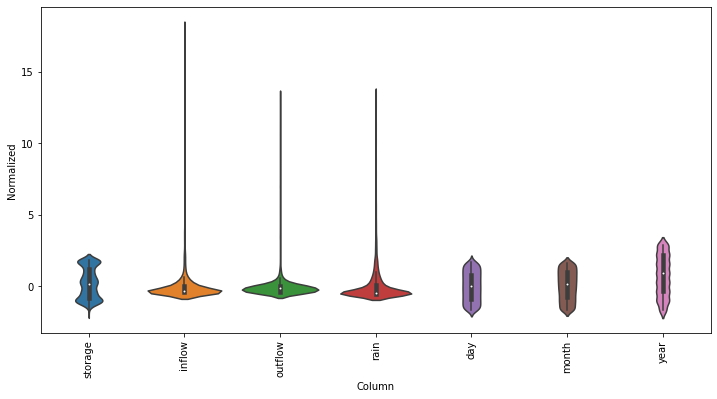

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
#Windowing
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift #maybe we should change this for when we have many outputs

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=SHIFT,
                     label_columns=['storage'])
w1

Total window size: 180
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Label indices: [179]
Label column name(s): ['storage']

In [ ]:
#split window into inputs and labels
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 180, 7)
Inputs shape: (3, 90, 7)
labels shape: (3, 1, 1)


In [ ]:
w1.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='storage', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time')

WindowGenerator.plot = plot

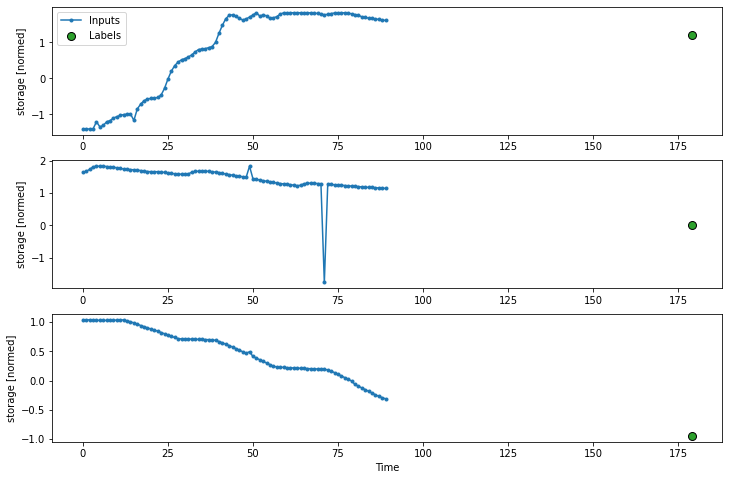

In [ ]:
w1.plot()

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
w1.train.element_spec

(TensorSpec(shape=(None, 90, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 90, 7)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
#wide_window and wide_conv_window is just for display purposes, it doesn't change the model
wide_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH_DISPLAY, shift=SHIFT,
    label_columns=['storage'])


for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

wide_window

Inputs shape (batch, time, features): (32, 90, 7)
Labels shape (batch, time, features): (32, 20, 1)


Total window size: 180
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Label indices: [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179]
Label column name(s): ['storage']

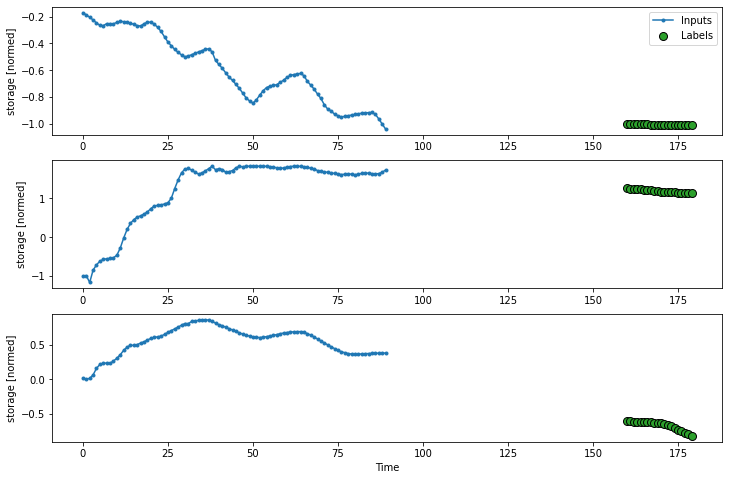

In [ ]:
wide_window.plot()

In [ ]:
conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=SHIFT,
    label_columns=['storage'])

conv_window

Total window size: 180
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Label indices: [179]
Label column name(s): ['storage']

In [ ]:
LABEL_WIDTH, INPUT_WIDTH, SHIFT

(1, 90, 90)

In [ ]:
#To-do: only for display. add plots for multiple outputs (wide window function)
print(LABEL_WIDTH_DISPLAY)
INPUT_WIDTH_NEW = LABEL_WIDTH_DISPLAY + (INPUT_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH_NEW,
    label_width=LABEL_WIDTH_DISPLAY,
    shift=SHIFT,
    label_columns=['storage'])

wide_conv_window

20


Total window size: 199
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108]
Label indices: [179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198]
Label column name(s): ['storage']

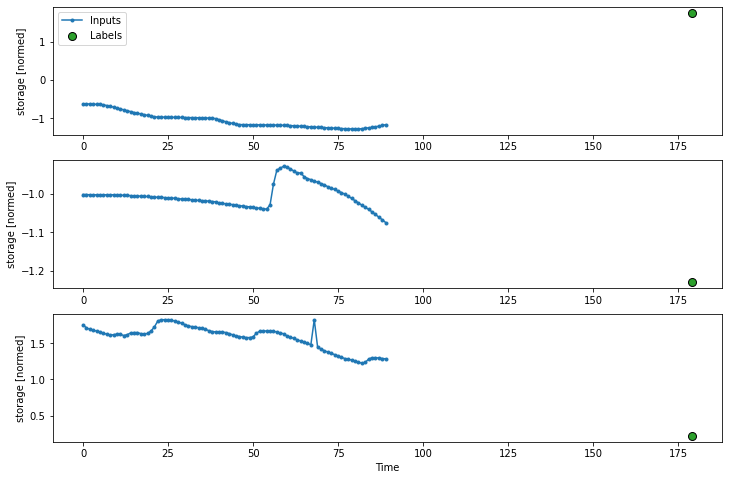

In [ ]:
conv_window.plot()

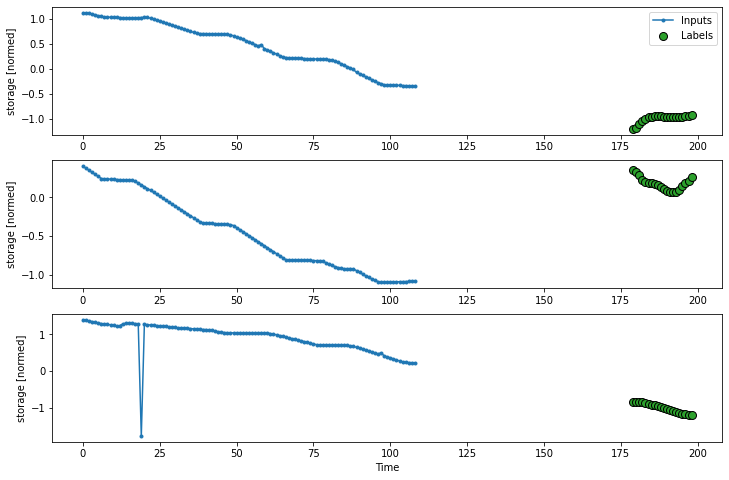

In [ ]:
wide_conv_window.plot()

In [ ]:
#to-do: build a baseline model (maybe simple auto-regressive model)
# build simpler models: linear, ARIMA, ...

# Various Models

## Learning Rate Optimization

In [ ]:
#LR-Finder (adopted from fast.ai)
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.callbacks import Callback


class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

#object creation
lr_finder=LRFinder()

In [ ]:
#Cyclic Learning Rate
!pip install tensorflow_addons
import tensorflow_addons as tfa
import math
MAX_LR=0.01 #from lr_finder graph. 1 order less than minima
MIN_LR=.001 # from lr_finder graph. 1/5th of max_lr
BATCH_SIZE=32
STEPS_PER_EPOCH=math.ceil(len(train_df)/BATCH_SIZE)#

def scale_fn(x):
    return 1/(2.**(x-1))

clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=MIN_LR,maximal_learning_rate=MAX_LR,
                                          scale_fn=scale_fn,
                                          step_size=2 * STEPS_PER_EPOCH
)

#It is usually used with SGD optimizer, but we are using with ADAM

     |████████████████████████████████| 679 kB 5.3 MB/s 


In [ ]:
#power scheduling learning rate

In [ ]:
#common function for all models
MAX_EPOCHS = 50

val_performance = {}
performance = {}
patience = 7 # stops training if overfitting. dont set it too low.
def compile_and_fit(model, window, patience=5, is_earlystopping=True, is_lr_finder=False, is_cyclic_lr=True):
  
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    
    
    if is_cyclic_lr:
        model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=clr),
                metrics=[tf.metrics.MeanAbsoluteError(), 
                         tf.metrics.MeanAbsolutePercentageError(), 
                         tf.metrics.RootMeanSquaredError()])
    else:
         model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(), 
                         tf.metrics.MeanAbsolutePercentageError(), 
                         tf.metrics.RootMeanSquaredError()])   
    
    callbacks=[]
    if is_lr_finder:
        if is_earlystopping:
            callbacks=[early_stopping, lr_finder]
        else:
            callbacks=[lr_finder]    
    
    if is_earlystopping:
        callbacks=[early_stopping]


    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=callbacks)
    return history

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [ ]:
len(train_df)/32

59.46875

In [ ]:
# # This model is only for testing hyperparameters - dropout, kernel_regulaizer, etc,
# DROPOUT=0.3
# RECURRENT_DROPOUT=0.3

# # we change optimizer in compiler function to remove learning_rate=clr
# lstm_cyclic_lr = tf.keras.models.Sequential([
#     # Shape [batch, time, features] => [batch, time, lstm_units]
#     tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
#     tf.keras.layers.LSTM(units=32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)),
#     tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)),
#     tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)),
#     # Shape => [batch, time, features]
#     tf.keras.layers.Dense(units=1)
# ])

# history = compile_and_fit(lstm_cyclic_lr, conv_window, is_earlystopping=False, is_lr_finder=False, 
#                           is_cyclic_lr=True)    


# #IPython.display.clear_output()
# plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
# lr_finder.plot()

In [ ]:
# step = np.arange(0,MAX_EPOCHS * 200)
# lr = clr(step)
# plt.plot(step, lr)
# plt.xlabel("Steps")
# plt.ylabel("Learning Rate")
# plt.show()


## Models

In [ ]:
# # Model 0: ARIMA
# #!pip install pmdarima
# from pmdarima import auto_arima
  
# # Ignore harmless warnings
# import warnings
# warnings.filterwarnings("ignore")
  
# # Fit auto_arima function to AirPassengers dataset
# stepwise_fit = auto_arima(inputs['storage'], start_p = 1, start_q = 1,
#                           max_p = 3, max_q = 3, m = 12,
#                           start_P = 0, seasonal = True,
#                           d = None, D = 1, trace = True,
#                           error_action ='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings = True,  # we don't want convergence warnings
#                           stepwise = True)           # set to stepwise
  
# # To print the summary
# stepwise_fit.summary()


Best model:  ARIMA(2,0,0)(2,1,0)[12]          
Total fit time: 378.848 seconds

SARIMAX Results Dep. Variable: 	y 	No. Observations: 	3306
Model: 	SARIMAX(2, 0, 0)x(2, 1, 0, 12) 	Log Likelihood 	-6571.364
Date: 	Sat, 17 Jul 2021 	AIC 	13152.729
Time: 	04:08:47 	BIC 	13183.228
Sample: 	0 	HQIC 	13163.647
	- 3306 		
Covariance Type: 	opg 		
	coef 	std err 	z 	P>|z| 	[0.025 	0.975]
ar.L1 	0.6936 	0.002 	326.821 	0.000 	0.689 	0.698
ar.L2 	0.2822 	0.004 	72.697 	0.000 	0.275 	0.290
ar.S.L12 	-0.6670 	0.003 	-210.457 	0.000 	-0.673 	-0.661
ar.S.L24 	-0.3176 	0.003 	-98.993 	0.000 	-0.324 	-0.311
sigma2 	3.1570 	0.008 	381.105 	0.000 	3.141 	3.173
Ljung-Box (L1) (Q): 	0.12 	Jarque-Bera (JB): 	5238207.52
Prob(Q): 	0.73 	Prob(JB): 	0.00
Heteroskedasticity (H): 	0.17 	Skew: 	-4.50
Prob(H) (two-sided): 	0.00 	Kurtosis: 	198.15


Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

In [ ]:
# # Model 1: multi-step dense. (Fully-connected NN)
# multi_step_dense = tf.keras.Sequential([
#     # Shape: (time, features) => (time*features)
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=32, activation='relu'),
#     tf.keras.layers.Dense(units=32, activation='relu'),
#     tf.keras.layers.Dense(units=32, activation='relu'),
#     tf.keras.layers.Dense(units=1),
#     # Add back the time dimension.
#     # Shape: (outputs) => (1, outputs)
#     tf.keras.layers.Reshape([1, -1]),
# ])

In [ ]:
# print('Input shape:', conv_window.example[0].shape)
# print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

In [ ]:
# history = compile_and_fit(multi_step_dense, conv_window)

# IPython.display.clear_output()
# val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
# performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

In [ ]:
# plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
#Model 2: Conv-dense. same model but more flexible for different input shapes.
dense_nn = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,kernel_size=(INPUT_WIDTH,),activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001) ),
    tf.keras.layers.Dropout(rate=DROPOUT),
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)),
    tf.keras.layers.Dropout(rate=DROPOUT),
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Dense model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', dense_nn(conv_window.example[0]).shape)

Dense model on `conv_window`
Input shape: (32, 90, 7)
Output shape: (32, 1, 1)


12/12 [==============================] - 0s 4ms/step - loss: 0.9904 - mean_absolute_error: 0.5614 - mean_absolute_percentage_error: 434.9473 - root_mean_squared_error: 0.9098


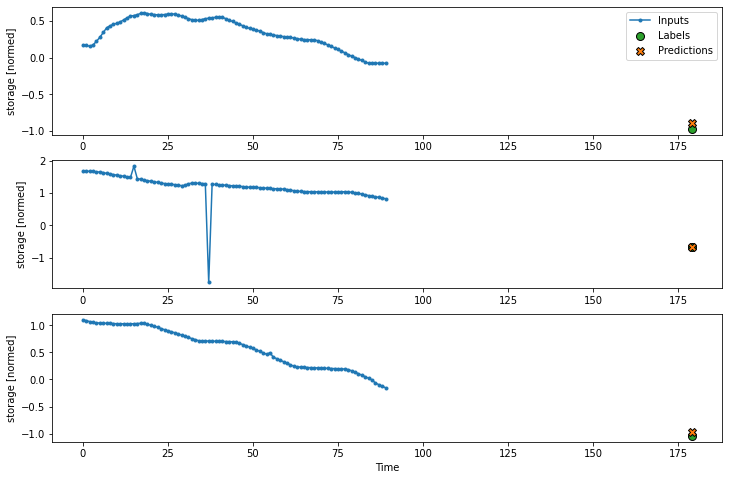

In [ ]:
history = compile_and_fit(dense_nn, conv_window)

IPython.display.clear_output()
val_performance['dense_nn'] = dense_nn.evaluate(conv_window.val)
performance['dense_nn'] = dense_nn.evaluate(conv_window.test, verbose=0)

conv_window.plot(dense_nn)

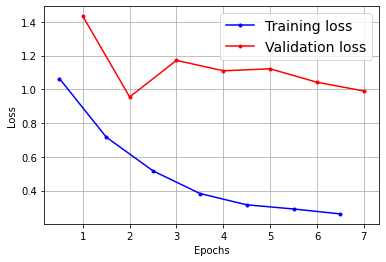

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
dense_nn.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_dense_nn')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_dense_nn/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_dense_nn/assets


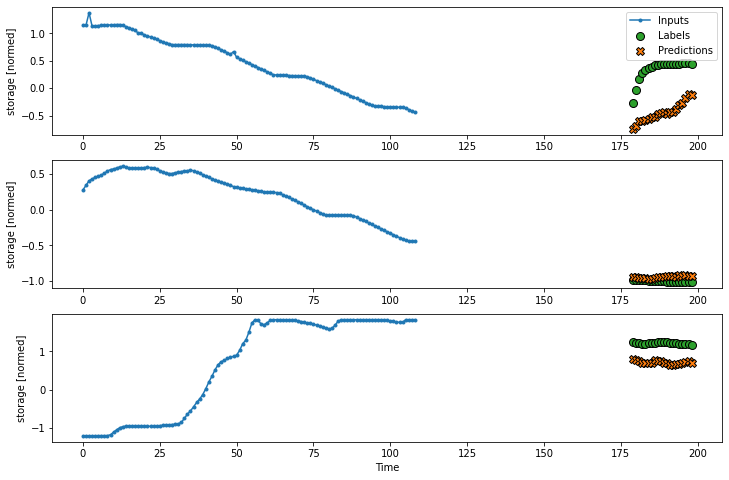

In [ ]:
wide_conv_window.plot(dense_nn)

In [ ]:
# Model 3: Recurrent Neural Network - LSTM (Simple)
lstm_basic = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001) ),#model outputs all intermediate predictions as well. If training a deep network, need this for all layers except the last
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_basic(conv_window.example[0]).shape) #check output shape. should be (32, 1,1)

Input shape: (32, 90, 7)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(lstm_basic, conv_window)

IPython.display.clear_output()
val_performance['lstm_basic'] = lstm_basic.evaluate(conv_window.val)
performance['lstm_basic'] = lstm_basic.evaluate(conv_window.test, verbose=0)

12/12 [==============================] - 0s 4ms/step - loss: 1.1593 - mean_absolute_error: 0.7954 - mean_absolute_percentage_error: 123.3844 - root_mean_squared_error: 1.0598


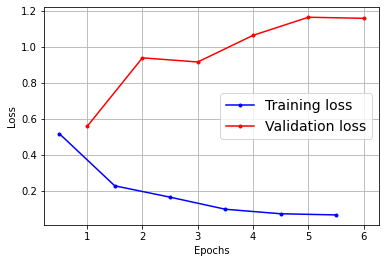

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

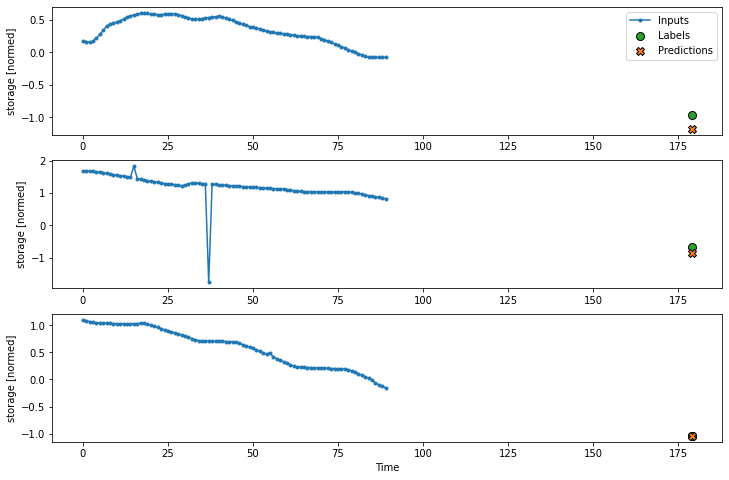

In [ ]:
conv_window.plot(lstm_basic)

In [ ]:
lstm_basic.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_lstm_basic')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_lstm_basic/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_lstm_basic/assets


In [ ]:
# # Model 4: LSTM with Residual connections. (IMPLEMENTED WRONGLY> SKIP IT.)
# class ResidualWrapper(tf.keras.Model):
#   def __init__(self, model):
#     super().__init__()
#     self.model = model

#   def call(self, inputs, *args, **kwargs):
#     delta = self.model(inputs, *args, **kwargs)

#     # The prediction for each timestep is the input
#     # from the previous time step plus the delta
#     # calculated by the model.
#     return inputs + delta

In [ ]:
# residual_lstm = ResidualWrapper(
#     tf.keras.Sequential([
#     tf.keras.layers.LSTM(32, return_sequences=True),
#     tf.keras.layers.Dense(
#         num_features,
#         # The predicted deltas should start small
#         # So initialize the output layer with zeros
#         kernel_initializer=tf.initializers.zeros()),
#     tf.keras.layers.Dense(1)  #dont know if last layer should be added  
# ]))


In [ ]:
# print('Input shape:', conv_window.example[0].shape)
# print('Output shape:', residual_lstm(conv_window.example[0]).shape) #check output shape. should be (32, 1,1)


In [ ]:

# history = compile_and_fit(residual_lstm, conv_window)

# IPython.display.clear_output()
# val_performance['residual_lstm'] = residual_lstm.evaluate(conv_window.val)
# performance['residual_lstm'] = residual_lstm.evaluate(conv_window.test, verbose=0)

In [ ]:
# residual_lstm.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_residual_lstm')

In [ ]:
#take it deeper
#add layer norm
#add conv layer
#add dropout, recurrent_dropout. May also evaluate uncertainty using Monte-Carlo Dropout
#try WaveNet
#try bi-directional LSTM, GRU
#add cross-batch statefulness

In [ ]:
# # Model 5: Deep LSTM
# !pip install tensorflow_addons
# import tensorflow_addons as tfa
# lnLSTMCell = tfa.rnn.LayerNormLSTMCell(units=32) 


# deep_lstm_model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
#     # Shape [batch, time, features] => [batch, time, lstm_units]
#     tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
#     tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
#     tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
#     #If using Dense layer at the end (which you should), remove return_sequences=True from second last layer
#     # Shape => [batch, time, features]
#     tf.keras.layers.Dense(units=1)
# ])

In [ ]:
# print('Input shape:', conv_window.example[0].shape)
# print('Output shape:', deep_lstm_model(conv_window.example[0]).shape)
# #expected (32, 1, 1). It is because of return_sequences=True and Conv1D

In [ ]:
# history = compile_and_fit(deep_lstm_model, conv_window)

# IPython.display.clear_output()
# val_performance['Deep_LSTM'] = deep_lstm_model.evaluate(conv_window.val)
# performance['Deep_LSTM'] = deep_lstm_model.evaluate(conv_window.test, verbose=0)

In [ ]:
# plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
# #Model 6: Deep LSTM with Conv; without Layer Normalization
# deep_lstm_model_2 = tf.keras.models.Sequential([
#     # Shape [batch, time, features] => [batch, time, lstm_units]
#     tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
#     tf.keras.layers.LSTM(units=32, return_sequences=True),
#     tf.keras.layers.LSTM(units=32, return_sequences=True),
#     tf.keras.layers.LSTM(units=32, return_sequences=True),
#     # Shape => [batch, time, features]
#     tf.keras.layers.Dense(units=1)
# ])

In [ ]:
# print('Input shape:', conv_window.example[0].shape)
# print('Output shape:', deep_lstm_model_2(conv_window.example[0]).shape)


In [ ]:
# history = compile_and_fit(deep_lstm_model_2, conv_window)

# IPython.display.clear_output()
# val_performance['Deep_LSTM_2'] = deep_lstm_model_2.evaluate(wide_window.val)
# performance['Deep_LSTM_2'] = deep_lstm_model_2.evaluate(wide_window.test, verbose=0)

In [ ]:
# plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
# Model 7: WaveNet
wavenet = tf.keras.models.Sequential()
wavenet.add(tf.keras.layers.Conv1D(filters=20, kernel_size=INPUT_WIDTH, strides=2, padding='valid'))
#wavenet.add(tf.keras.layers.InputLayer(input_shape=[None, 7]))# explicitly telling input shape. [None, #features]
for rate in (1, 2, 4, 8, 16, 32) * 2:
    wavenet.add(tf.keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate, kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001) ))
wavenet.add(tf.keras.layers.Conv1D(filters=10, kernel_size=1))
wavenet.add(tf.keras.layers.Dense(1))

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', wavenet(conv_window.example[0]).shape) #check shape. should be (32, 1, 1)

Input shape: (32, 90, 7)
Output shape: (32, 1, 1)


In [ ]:
wavenet.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (32, 1, 20)               12620     
_________________________________________________________________
conv1d_22 (Conv1D)           (32, 1, 20)               820       
_________________________________________________________________
conv1d_23 (Conv1D)           (32, 1, 20)               820       
_________________________________________________________________
conv1d_24 (Conv1D)           (32, 1, 20)               820       
_________________________________________________________________
conv1d_25 (Conv1D)           (32, 1, 20)               820       
_________________________________________________________________
conv1d_26 (Conv1D)           (32, 1, 20)               820       
_________________________________________________________________
conv1d_27 (Conv1D)           (32, 1, 20)             

In [ ]:
history = compile_and_fit(wavenet, conv_window)

IPython.display.clear_output()
val_performance['wavenet'] = wavenet.evaluate(conv_window.val)
performance['wavenet'] = wavenet.evaluate(conv_window.test, verbose=0)

12/12 [==============================] - 0s 5ms/step - loss: 1.7912 - mean_absolute_error: 1.1765 - mean_absolute_percentage_error: 197.5070 - root_mean_squared_error: 1.3372


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_wavenet/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_wavenet/assets


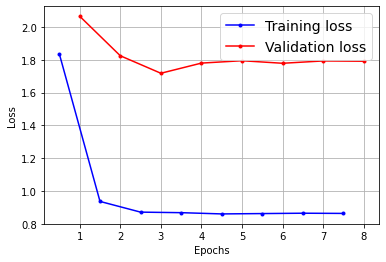

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
wavenet.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_wavenet')

In [ ]:
# Model 8: LSTM with dropout (becasue all the above models seem to overfit)
DROPOUT=0.2
RECURRENT_DROPOUT=0.2

lstm_deep_1 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, ),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_deep_1(conv_window.example[0]).shape)


Input shape: (32, 90, 7)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(lstm_deep_1, conv_window)

IPython.display.clear_output()
val_performance['lstm_deep_1'] = lstm_deep_1.evaluate(conv_window.val)
performance['lstm_deep_1'] = lstm_deep_1.evaluate(conv_window.test, verbose=0)

12/12 [==============================] - 0s 4ms/step - loss: 1.0168 - mean_absolute_error: 0.8380 - mean_absolute_percentage_error: 638.6520 - root_mean_squared_error: 1.0084


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_lstm_deep_1/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_lstm_deep_1/assets


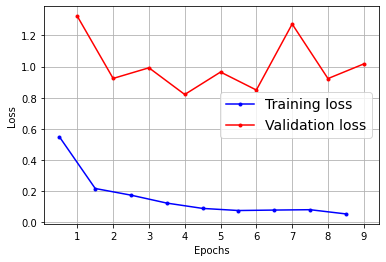

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
lstm_deep_1.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_lstm_deep_1')

In [ ]:
# Model 9: LSTM with dropout, conv, layer norm
DROPOUT=0.3
RECURRENT_DROPOUT=0.3
#!pip install tensorflow_addons
import tensorflow_addons as tfa
lnLSTMCell = tfa.rnn.LayerNormLSTMCell(units=32, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)) 
lstm_deep_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True,  ),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True, ),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True, ),
    #If using Dense layer at the end (which you should), remove return_sequences=True from second last layer
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_deep_2(conv_window.example[0]).shape)


Input shape: (32, 90, 7)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(lstm_deep_2, conv_window)

IPython.display.clear_output()
val_performance['lstm_deep_2'] = lstm_deep_2.evaluate(conv_window.val)
performance['lstm_deep_2'] = lstm_deep_2.evaluate(conv_window.test, verbose=0)

12/12 [==============================] - 0s 4ms/step - loss: 1.1256 - mean_absolute_error: 0.8303 - mean_absolute_percentage_error: 891.5741 - root_mean_squared_error: 0.9763


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_lstm_deep_2/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_lstm_deep_2/assets


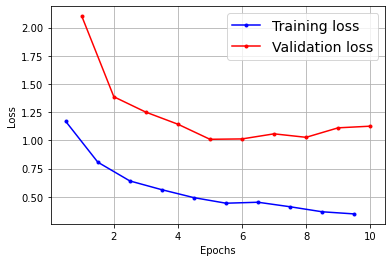

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
lstm_deep_2.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_lstm_deep_2')

In [ ]:
#wide_conv_window.plot(lstm_deep_2)

In [ ]:
# Model: Very Deep LSTM
DROPOUT=0.3
RECURRENT_DROPOUT=0.3
#!pip install tensorflow_addons
import tensorflow_addons as tfa
lnLSTMCell = tfa.rnn.LayerNormLSTMCell(units=32, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, 
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)) 
lstm_deep_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    
    #If using Dense layer at the end (which you should), remove return_sequences=True from second last layer
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_deep_3(conv_window.example[0]).shape)

Input shape: (32, 90, 7)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(lstm_deep_3, conv_window)

IPython.display.clear_output()
val_performance['lstm_deep_3'] = lstm_deep_3.evaluate(conv_window.val)
performance['lstm_deep_3'] = lstm_deep_3.evaluate(conv_window.test, verbose=0)

12/12 [==============================] - 0s 7ms/step - loss: 3.0511 - mean_absolute_error: 1.3029 - mean_absolute_percentage_error: 613.8799 - root_mean_squared_error: 1.6376


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_lstm_deep_3/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_lstm_deep_3/assets


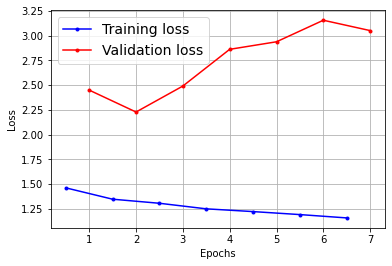

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
lstm_deep_3.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_lstm_deep_3')

In [ ]:
SHIFT

90

# Saving Predictions

In [ ]:
model_list=['dense_nn', 'lstm_basic','wavenet','lstm_deep_1', 'lstm_deep_2', 'lstm_deep_3']
#Run everything except models to run this block. (Run Learning Rate Optimizers as well)

90

In [ ]:
#for finding labels dates.
conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=SHIFT,
    )

print(conv_window)


sample_nn = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,kernel_size=(INPUT_WIDTH,),activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001) ),
    tf.keras.layers.Dropout(rate=DROPOUT),
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)),
    tf.keras.layers.Dropout(rate=DROPOUT),
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)),
    tf.keras.layers.Dense(units=7),
])

print("Dense model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', sample_nn(conv_window.example[0]).shape)

history = compile_and_fit(sample_nn, conv_window)

Total window size: 180
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
Label indices: [179]
Label column name(s): None
Dense model on `conv_window`
Input shape: (32, 90, 7)
Output shape: (32, 1, 7)
Epoch 1/50
54/54 [==============================] - 1s 12ms/step - loss: 1.2920 - mean_absolute_error: 0.6159 - mean_absolute_percentage_error: 343.6943 - root_mean_squared_error: 0.8962 - val_loss: 1.7473 - val_mean_absolute_error: 0.7662 - val_mean_absolute_percentage_error: 321.4666 - val_root_mean_squared_error: 1.1590
Epoch 2/50
54/54 [==============================] - 0s 7ms/step - loss: 0.9564 - mean_absolute_error: 0.5103 - mean_absolute_percentage_error: 322.9789 - root_mean_squared_error: 0.7926 - val_loss: 1.7152 - val_mean_absolute_error: 0.7

In [ ]:
    predictions=sample_nn.predict(conv_window.test)

    #getting truth_value
    inputs_f=[]
    labels_f=[]
    i=0
    for inputs, labels in conv_window.test.take(-1):

        print(inputs.shape, labels.shape, i)
        if i==0:
            inputs_f=inputs
            labels_f=labels
        else:
            inputs_f=tf.concat([inputs_f, inputs], axis=0)
            labels_f=tf.concat([labels_f, labels], axis=0)
        i +=1

    #un-normalize
    #predictions=predictions*train_std+train_mean
    labels_f=labels_f*train_std+train_mean
    inputs_f=inputs_f*train_std+train_mean

    #reshape, store
    #labels_f=labels_f.numpy().reshape(-1)
    #predictions=predictions.reshape(-1)
    #print(labels_f.shape, predictions.shape)
    #print('model: ', models, ' sample truth: ', labels_f[0:5], ' predictions ', predictions[0:5])

In [ ]:
labels_f=labels_f*train_std+train_mean
inputs_f=inputs_f*train_std+train_mean


In [ ]:
inputs_f[-1,:,4:7]

<tf.Tensor: shape=(90, 3), dtype=float32, numpy=
array([[2.5000000e+01, 4.0000000e+00, 2.0200000e+03],
       [2.6000000e+01, 4.0000000e+00, 2.0200000e+03],
       [2.7000000e+01, 4.0000000e+00, 2.0200000e+03],
       [2.8000000e+01, 4.0000000e+00, 2.0200000e+03],
       [2.9000000e+01, 4.0000000e+00, 2.0200000e+03],
       [3.0000000e+01, 4.0000000e+00, 2.0200000e+03],
       [1.0000019e+00, 5.0000000e+00, 2.0200000e+03],
       [2.0000010e+00, 5.0000000e+00, 2.0200000e+03],
       [3.0000010e+00, 5.0000000e+00, 2.0200000e+03],
       [4.0000010e+00, 5.0000000e+00, 2.0200000e+03],
       [5.0000010e+00, 5.0000000e+00, 2.0200000e+03],
       [6.0000010e+00, 5.0000000e+00, 2.0200000e+03],
       [7.0000010e+00, 5.0000000e+00, 2.0200000e+03],
       [8.0000010e+00, 5.0000000e+00, 2.0200000e+03],
       [9.0000010e+00, 5.0000000e+00, 2.0200000e+03],
       [1.0000000e+01, 5.0000000e+00, 2.0200000e+03],
       [1.1000000e+01, 5.0000000e+00, 2.0200000e+03],
       [1.2000000e+01, 5.0000000e

In [ ]:
labels_f[:,:,4:6]

<tf.Tensor: shape=(93, 1, 2), dtype=float32, numpy=
array([[[17.       , 11.       ]],

       [[17.       ,  9.       ]],

       [[19.       ,  9.       ]],

       [[30.       ,  9.       ]],

       [[14.000001 , 11.       ]],

       [[ 6.000001 , 12.       ]],

       [[20.       ,  9.       ]],

       [[ 4.000001 , 11.       ]],

       [[ 4.000001 , 10.       ]],

       [[27.       ,  9.       ]],

       [[14.000001 , 10.       ]],

       [[ 1.0000019, 10.       ]],

       [[25.       , 11.       ]],

       [[ 3.000001 , 10.       ]],

       [[16.       ,  9.       ]],

       [[ 2.000001 , 11.       ]],

       [[20.       , 11.       ]],

       [[13.000001 , 11.       ]],

       [[26.       , 10.       ]],

       [[31.       , 10.       ]],

       [[12.       , 12.       ]],

       [[13.000001 , 10.       ]],

       [[18.       , 10.       ]],

       [[ 3.000001 , 12.       ]],

       [[15.       , 11.       ]],

       [[24.       ,  9.       ]],

       [[ 1.

In [ ]:
for models in model_list:
    model=tf.keras.models.load_model(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_{models}',
                                     custom_objects={"scale_fn": scale_fn})
    predictions=model.predict(conv_window.test)

    #getting truth_value
    #inputs_f=[]
    labels_f=[]
    i=0
    for _, labels in conv_window.test.take(-1):

        #print(inputs.shape, labels.shape, i)
        if i==0:
            #inputs_f=inputs
            labels_f=labels
        else:
            #inputs_f=tf.concat([inputs_f, inputs], axis=0)
            labels_f=tf.concat([labels_f, labels], axis=0)
        i +=1

    #un-normalize
    predictions=predictions*train_std[0]+train_mean[0]
    labels_f=labels_f*train_std[0]+train_mean[0]

    #reshape, store
    labels_f=labels_f.numpy().reshape(-1)
    predictions=predictions.reshape(-1)
    print(labels_f.shape, predictions.shape)
    print('model: ', models, ' sample truth: ', labels_f[0:5], ' predictions ', predictions[0:5])
    df = pd.DataFrame({"true" : labels_f, "prediction" : predictions})
    df.to_csv(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/predictions/{DAM}_{SHIFT}_{models}_predictions.csv', index=False)

#need to recheck why sample_truth is different in both


(93,) (93,)
model:  dense_nn  sample truth:  [46.370003 43.04     49.449997 48.68     49.449997]  predictions  [44.171665 55.10081  55.17387  57.80475  60.84353 ]
(93,) (93,)
model:  lstm_basic  sample truth:  [43.04     46.61     49.449997 48.6      49.449997]  predictions  [45.28475  45.78734  46.27796  46.484116 30.643192]
(93,) (93,)
model:  wavenet  sample truth:  [49.449997 48.519997 45.82     49.449997 45.34    ]  predictions  [22.888496 22.888496 22.888496 22.888496 22.888496]


(93,) (93,)
model:  lstm_deep_1  sample truth:  [49.449997 48.91     43.04     49.449997 45.57    ]  predictions  [33.799408 38.207077 39.229137 38.2402   33.463432]


(93,) (93,)
model:  lstm_deep_2  sample truth:  [45.34     49.27     49.449997 46.82     49.449997]  predictions  [40.17218  40.199173 40.335    40.229195 40.42431 ]
(93,) (93,)
model:  lstm_deep_3  sample truth:  [49.449997 48.059998 49.449997 47.73     49.449997]  predictions  [14.866505 15.183177 15.137511 15.225419 15.209545]


# Performance and Visualizations

In [ ]:
model_list=['dense_nn', 'lstm_basic', 'wavenet', 'lstm_deep_1', 'lstm_deep_2', 'lstm_deep_3']
for models in model_list:
    print(models)
    model=tf.keras.models.load_model(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_{models}',
                                     custom_objects={"scale_fn": scale_fn})
    val_performance[models] = model.evaluate(conv_window.val)
    performance[models] = model.evaluate(conv_window.test, verbose=0)


dense_nn
12/12 [==============================] - 0s 4ms/step - loss: 0.9904 - mean_absolute_error: 0.5614 - mean_absolute_percentage_error: 434.9474 - root_mean_squared_error: 0.9098
lstm_basic
12/12 [==============================] - 0s 5ms/step - loss: 1.1593 - mean_absolute_error: 0.7954 - mean_absolute_percentage_error: 123.3844 - root_mean_squared_error: 1.0598
wavenet
12/12 [==============================] - 1s 5ms/step - loss: 1.7912 - mean_absolute_error: 1.1765 - mean_absolute_percentage_error: 197.5070 - root_mean_squared_error: 1.3372
lstm_deep_1


12/12 [==============================] - 4s 4ms/step - loss: 1.0168 - mean_absolute_error: 0.8380 - mean_absolute_percentage_error: 638.6519 - root_mean_squared_error: 1.0084
lstm_deep_2
12/12 [==============================] - 1s 6ms/step - loss: 1.1256 - mean_absolute_error: 0.8303 - mean_absolute_percentage_error: 891.5740 - root_mean_squared_error: 0.9763
lstm_deep_3
12/12 [==============================] - 3s 7ms/step - loss: 3.0511 - mean_absolute_error: 1.3029 - mean_absolute_percentage_error: 613.8799 - root_mean_squared_error: 1.6376


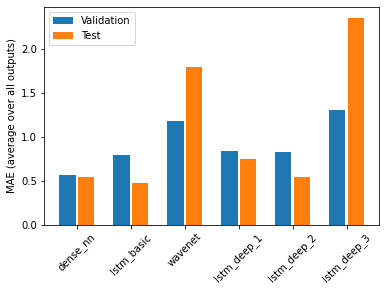

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_deep_2.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

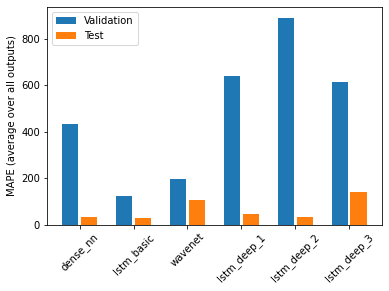

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_percentage_error'
metric_index = lstm_deep_2.metrics_names.index('mean_absolute_percentage_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAPE (average over all outputs)')
_ = plt.legend()

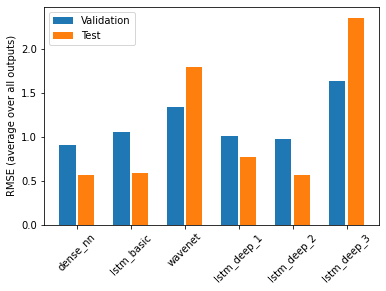

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'root_mean_squared_error'
metric_index = lstm_deep_2.metrics_names.index('root_mean_squared_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('RMSE (average over all outputs)')
_ = plt.legend()

# SHAP Values

In [ ]:
#getting truth_value
test_df3=[]
train_df3=[]
i=0
for inputs, _ in conv_window.test.take(-1):
    #print(inputs.shape, i)
    if i==0:
        test_df3=inputs
    else:
        test_df3=tf.concat([test_df3, inputs], axis=0)
    i +=1

i=0
for inputs, _ in conv_window.train.take(-1):
    #print(inputs.shape, i)
    if i==0:
        train_df3=inputs
    else:
        train_df3=tf.concat([train_df3, inputs], axis=0)
    i +=1


test_df3=test_df3.numpy()
train_df3=train_df3.numpy()
test_df3.shape, train_df3.shape #shap only accepts numpy array

((93, 90, 7), (1724, 90, 7))

In [ ]:
model_list=['lstm_deep_1']
for models in model_list:
    print(models)
    model=tf.keras.models.load_model(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_{models}',
                                     custom_objects={"scale_fn": scale_fn})
    model.add(tf.keras.layers.Reshape(target_shape=(1,))) #shap only accepts single number or vector


lstm_deep_1


In [ ]:
# preds=model.predict(conv_window.test)
# model.output_shape, preds.shape, train_df.shape, test_df.shape

In [ ]:
# model.add(tf.keras.layers.Reshape(target_shape=(1,)))

In [ ]:
# preds=model.predict(conv_window.test)
# model.output_shape, preds.shape, train_df.shape, test_df.shape

((None, 1), (93, 1, 1), (1903, 7), (272, 7))

In [ ]:
# type(model), type(test_df)

(tensorflow.python.keras.engine.sequential.Sequential,
 pandas.core.frame.DataFrame)

In [ ]:
# #test_df2=test_df.to_numpy()
# train_df2=train_df.to_numpy()

In [ ]:
# test_df2.shape, train_df2.shape

((272, 7), (1903, 7))

In [ ]:
# conv_window.train      #input,          output

<MapDataset shapes: ((None, 90, 7), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [ ]:
tf.compat.v1.disable_v2_behavior() #may cause MANY troubles, but sadly SHAP isn't fully compatible with Tensorflow 2.x.
#In general, run SHAP after you've done everything above. If you want to re-run codes with 2.x, do a factory reset runtime.

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
!pip install shap
import shap
explainer = shap.DeepExplainer(model, train_df3)
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(test_df3)


In [ ]:
# init the JS visualization code. #in google colab, in every cell you need a visualization, you'll need to call initjs()
shap.initjs() 
shap.force_plot(explainer.expected_value[0], shap_values[0][0], train_df.columns)

# Testing (Ignore)

In [ ]:
# dense_nn=tf.keras.models.load_model(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_dense_nn')

In [ ]:
# predictions=dense_nn.predict(conv_window.test)
# predictions.shape

(183, 1, 1)

In [ ]:
# conv_window.column_indices

{'day': 4,
 'inflow': 1,
 'month': 5,
 'outflow': 2,
 'rain': 3,
 'storage': 0,
 'year': 6}

In [ ]:
# inputs_f=[]
# labels_f=[]
# i=0
# for inputs, labels in conv_window.test.take(-1):

#     print(inputs.shape, labels.shape, i)
#     if i==0:
#         inputs_f=inputs
#         labels_f=labels
#     else:
#         inputs_f=tf.concat([inputs_f, inputs], axis=0)
#         labels_f=tf.concat([labels_f, labels], axis=0)
#     i +=1

(32, 60, 7) (32, 1, 1) 0
(32, 60, 7) (32, 1, 1) 1
(32, 60, 7) (32, 1, 1) 2
(32, 60, 7) (32, 1, 1) 3
(32, 60, 7) (32, 1, 1) 4
(23, 60, 7) (23, 1, 1) 5


In [ ]:
# inputs_f.shape, labels_f.shape
# labels_f[0:5,0,0]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 1.5260979 , -0.48903415,  1.5806001 ,  1.7739017 ,  1.7557342 ],
      dtype=float32)>

In [ ]:
# predictions=predictions*train_std[0]+train_mean[0]

In [ ]:
# inputs_f=inputs_f*train_std+train_mean
# labels_f=labels_f*train_std[0]+train_mean[0]
# labels_f[0:5, 0, 0]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([45.34, 17.61, 46.09, 48.75, 48.5 ], dtype=float32)>

In [ ]:
# labels_f[0:5, 0, 0], predictions[0:5, 0, 0]

(<tf.Tensor: shape=(5,), dtype=float32, numpy=array([45.34, 17.61, 46.09, 48.75, 48.5 ], dtype=float32)>,
 array([52.934948, 48.07469 , 45.32172 , 37.986588, 50.777897],
       dtype=float32))

In [ ]:
# labels_f=labels_f.numpy().reshape(-1)
# predictions=predictions.reshape(-1)
# labels_f.shape, predictions.shape

((183,), (183,))

In [ ]:
# !pwd

/content/gdrive/My Drive/Colab Notebooks/wave2web


In [ ]:
# df = pd.DataFrame({"true" : labels_f, "prediction" : predictions})
# df.to_csv(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/predictions/{DAM}_{SHIFT}_dense_nn_predictions.csv', index=False)

In [ ]:
# dates=tf.cast(inputs_f[:,:,4:7], dtype='int64')
# dates[-1, 55:61, :]

<tf.Tensor: shape=(5, 3), dtype=int64, numpy=
array([[  26,    8, 2020],
       [  27,    8, 2020],
       [  28,    8, 2020],
       [  29,    8, 2020],
       [  30,    8, 2020]])>